## Car Price Prediction 

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")

In [3]:
# summary of the dataset: 205 rows, 26 columns, no null values
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [4]:
# head
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [5]:
# symboling: -2 (least risky) to +3 most risky
# Most cars are 0,1,2
cars['symboling'].astype('category').value_counts()



 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

In [6]:
# aspiration: An (internal combustion) engine property showing 
# whether the oxygen intake is through standard (atmospheric pressure)
# or through turbocharging (pressurised oxygen intake)

cars['aspiration'].astype('category').value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [7]:
# drivewheel: frontwheel, rarewheel or four-wheel drive 
cars['drivewheel'].astype('category').value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

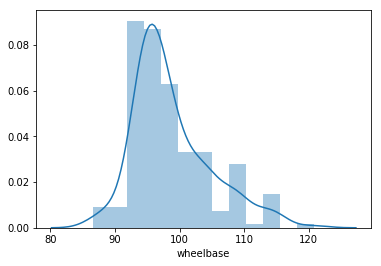

In [8]:
# wheelbase: distance between centre of front and rarewheels
sns.distplot(cars['wheelbase'])
plt.show()

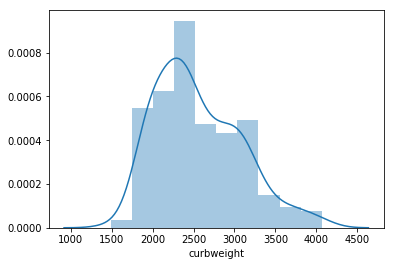

In [9]:
# curbweight: weight of car without occupants or baggage
sns.distplot(cars['curbweight'])
plt.show()

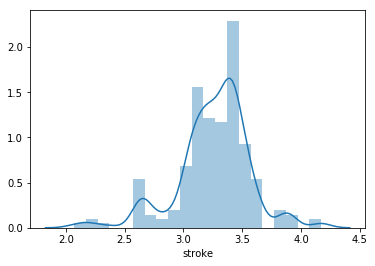

In [10]:
# stroke: volume of the engine (the distance traveled by the 
# piston in each cycle)
sns.distplot(cars['stroke'])
plt.show()

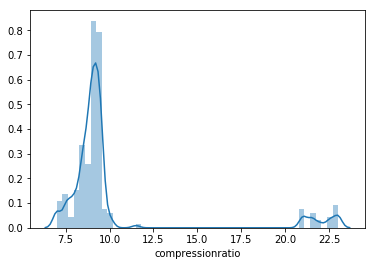

In [11]:
# compression ration: ratio of volume of compression chamber 
# at largest capacity to least capacity
sns.distplot(cars['compressionratio'])
plt.show()

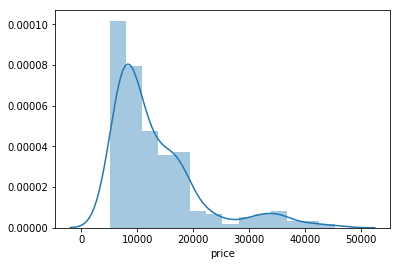

In [12]:
# target variable: price of car
sns.distplot(cars['price'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [20]:
# all numeric (float and int) variables in the dataset
cars_numeric = cars.select_dtypes(include=['float64', 'int64'])
cars_numeric.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


Here, although the variable ```symboling``` is numeric (int), we'd rather treat it as categorical since it has only 6 discrete values. Also, we do not want 'car_ID'.

In [21]:
# dropping symboling and car_ID 
cars_numeric = cars_numeric.drop(['symboling'], axis=1)
cars_numeric.head()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


Let's now make a pairwise scatter plot and observe linear relationships.

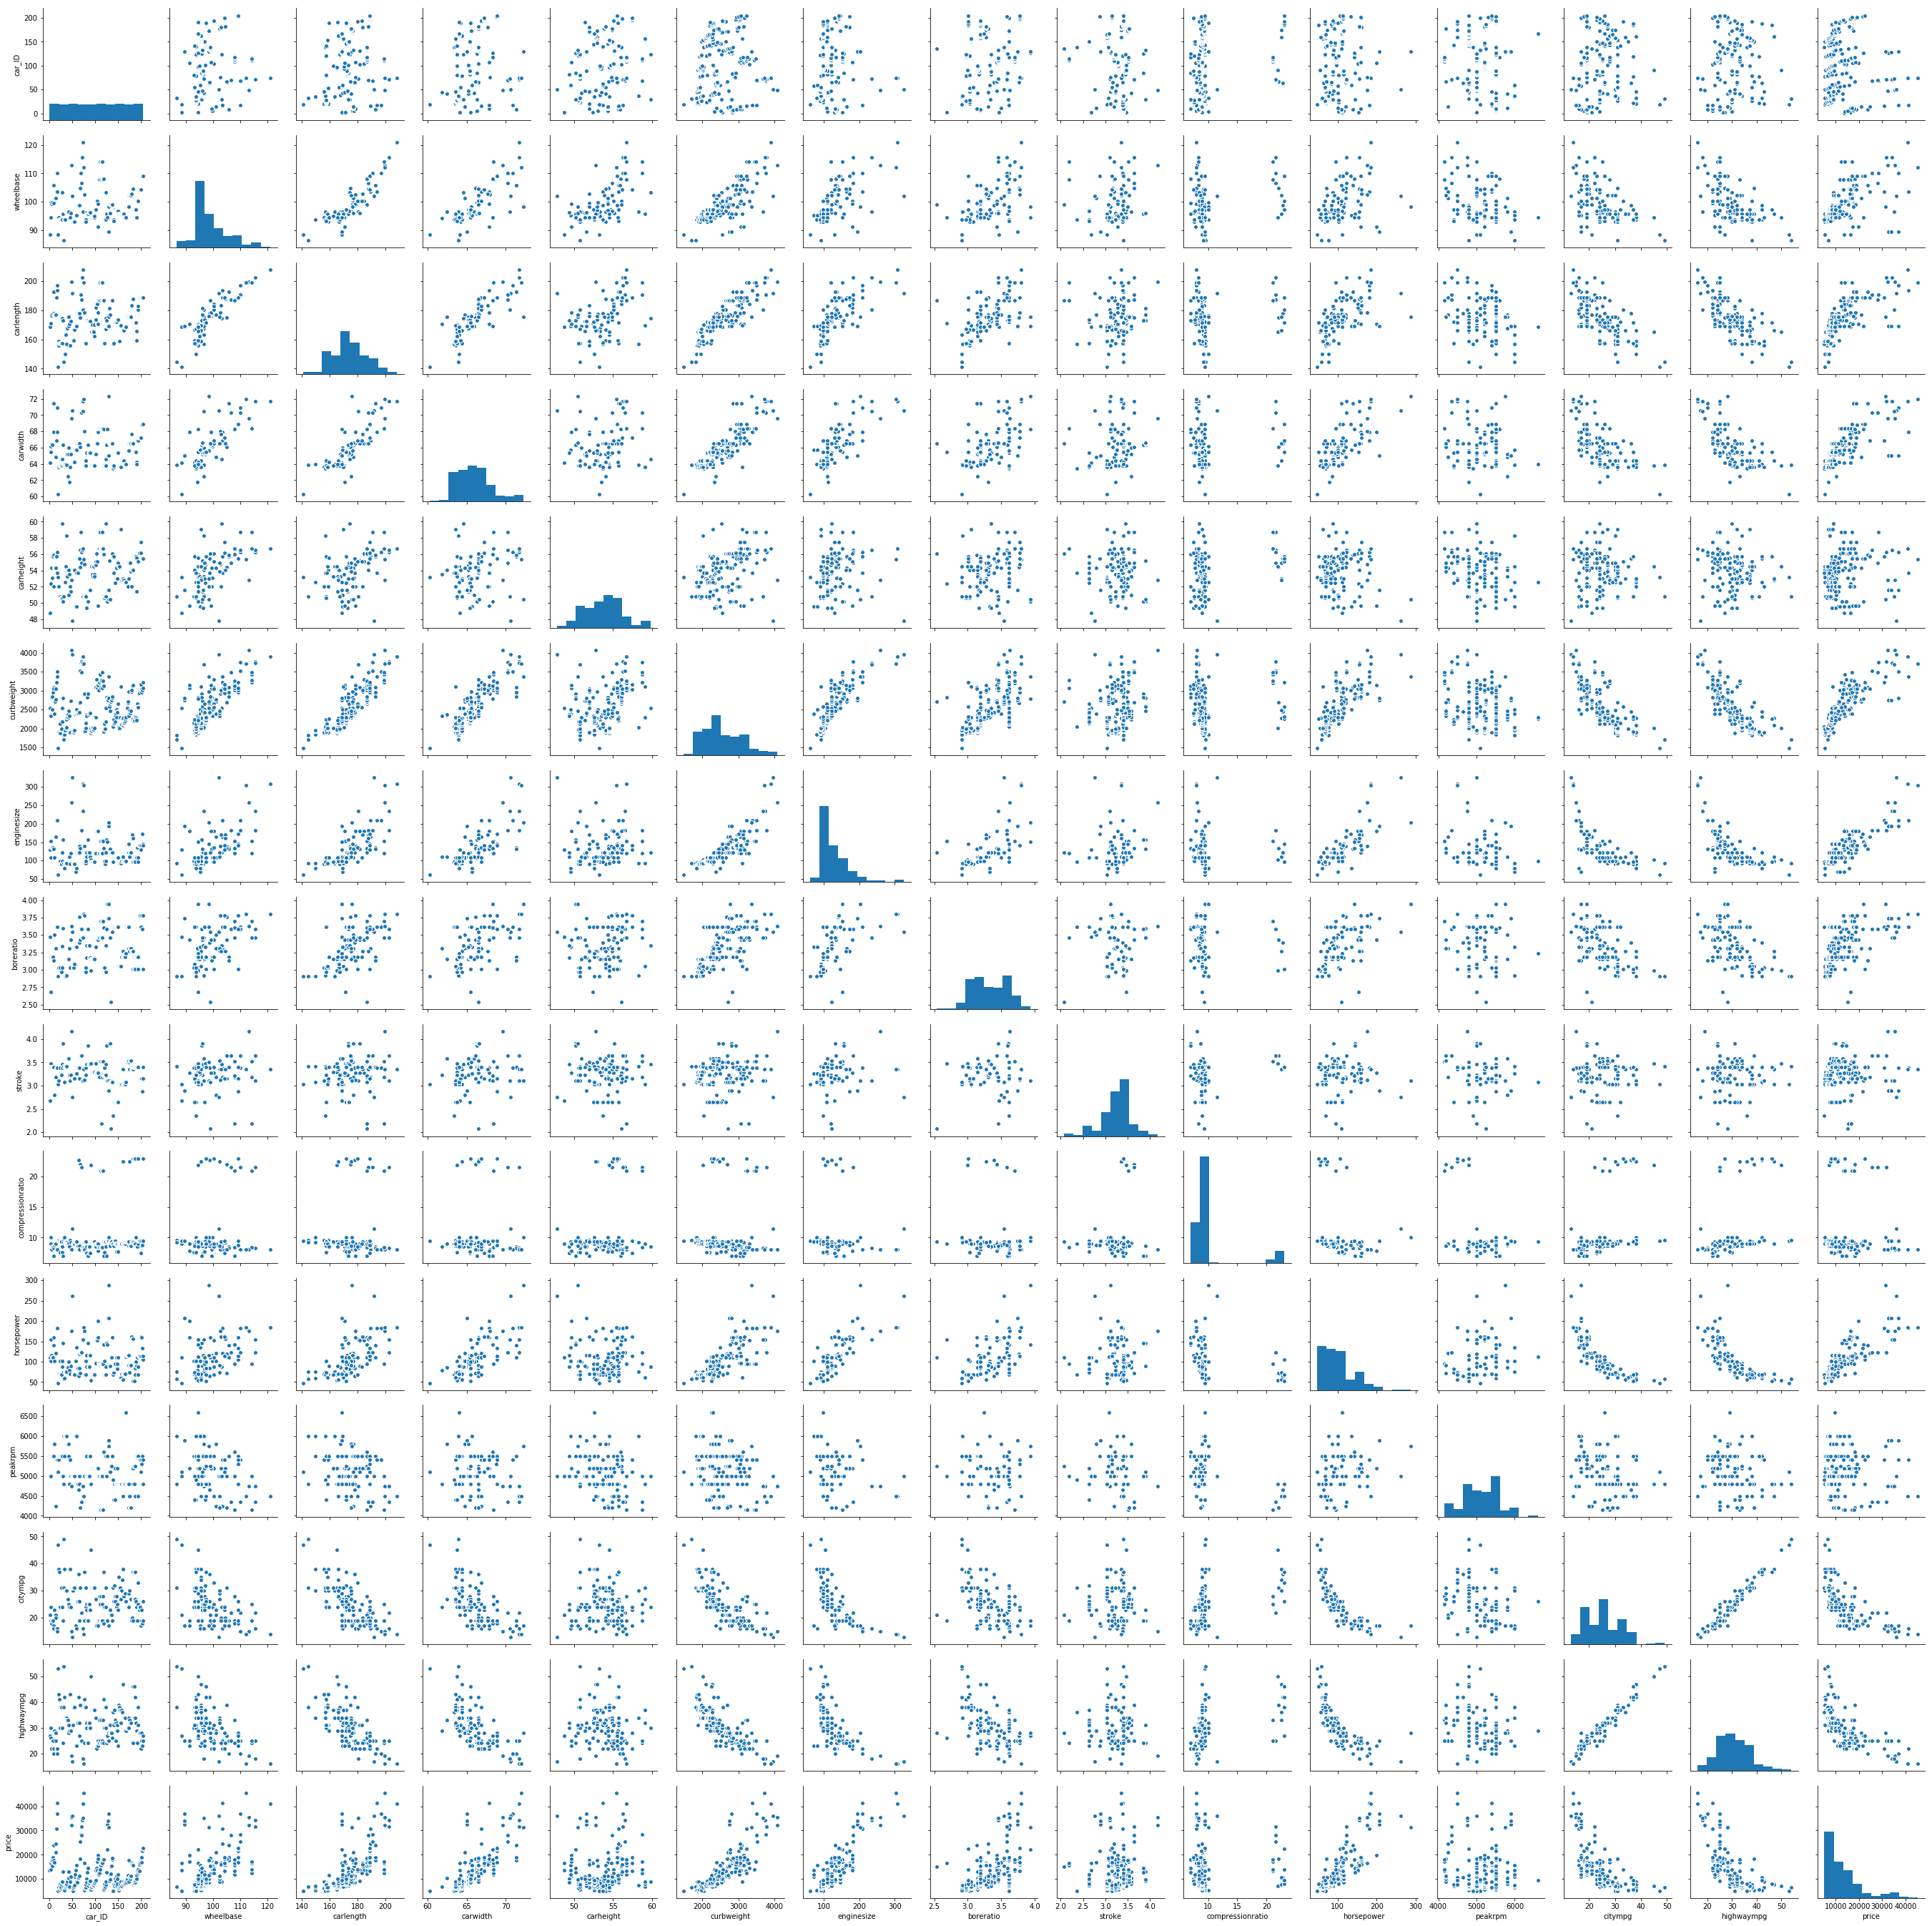

In [22]:
# paiwise scatter plot

plt.figure(figsize=(20, 10))
sns.pairplot(cars_numeric)
plt.show()

This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [23]:
# correlation matrix
cor = cars_numeric.corr()
cor

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.000000,0.129729,0.170636,0.052387,0.255960,0.071962,-0.033930,0.260064,-0.160824,0.150276,-0.015006,-0.203789,0.015940,0.011255,-0.109093
wheelbase,0.129729,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,0.170636,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,0.052387,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,0.255960,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,0.071962,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.033930,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,0.260064,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.160824,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443
compressionratio,0.150276,0.249786,0.158414,0.181129,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.265201,0.067984


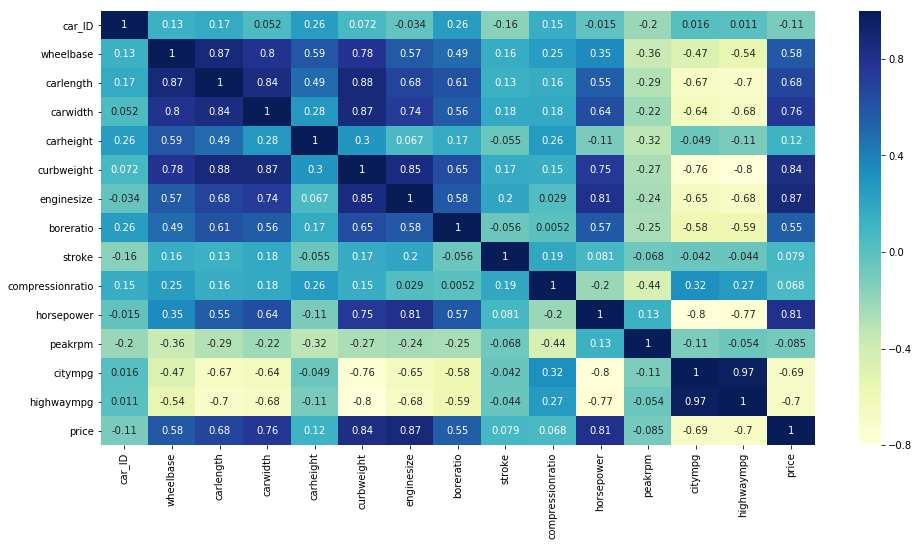

In [24]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


The heatmap shows some useful insights:

Correlation of price with independent variables:
- Price is highly (positively) correlated with wheelbase, carlength, carwidth, curbweight, enginesize, horsepower (notice how all of these variables represent the size/weight/engine power of the car)

- Price is negatively correlated to ```citympg``` and ```highwaympg``` (-0.70 approximately). This suggest that cars having high mileage may fall in the 'economy' cars category, and are priced lower (think Maruti Alto/Swift type of cars, which are designed to be affordable by the middle class, who value mileage more than horsepower/size of car etc.)

Correlation among independent variables:
- Many independent variables are highly correlated (look at the top-left part of matrix): wheelbase, carlength, curbweight, enginesize etc. are all measures of 'size/weight', and are positively correlated 


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 

We've seen that there are no missing values in the dataset. We've also seen that variables are in the correct format, except ```symboling```, which should rather be a categorical variable (so that dummy variable are created for the categories).

Note that it *can* be used in the model as a numeric variable also. 



In [25]:
# variable formats
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [26]:
# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null object
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm     

Netx, we need to extract the company name from the column ```CarName```. 

In [27]:
# CarName: first few entries
cars['CarName'][:30]

0            alfa-romero giulia
1           alfa-romero stelvio
2      alfa-romero Quadrifoglio
3                   audi 100 ls
4                    audi 100ls
5                      audi fox
6                    audi 100ls
7                     audi 5000
8                     audi 4000
9           audi 5000s (diesel)
10                     bmw 320i
11                     bmw 320i
12                       bmw x1
13                       bmw x3
14                       bmw z4
15                       bmw x4
16                       bmw x5
17                       bmw x3
18             chevrolet impala
19        chevrolet monte carlo
20          chevrolet vega 2300
21                dodge rampage
22          dodge challenger se
23                   dodge d200
24            dodge monaco (sw)
25           dodge colt hardtop
26              dodge colt (sw)
27         dodge coronet custom
28            dodge dart custom
29    dodge coronet custom (sw)
Name: CarName, dtype: object

Notice that the carname is what occurs before a space, e.g. alfa-romero, audi, chevrolet, dodge, bmx etc.

Thus, we need to simply extract the string before a space. There are multiple ways to do that.




In [28]:
# Extracting carname

# Method 1: str.split() by space
carnames = cars['CarName'].apply(lambda x: x.split(" ")[0])
carnames[:30]

0     alfa-romero
1     alfa-romero
2     alfa-romero
3            audi
4            audi
5            audi
6            audi
7            audi
8            audi
9            audi
10            bmw
11            bmw
12            bmw
13            bmw
14            bmw
15            bmw
16            bmw
17            bmw
18      chevrolet
19      chevrolet
20      chevrolet
21          dodge
22          dodge
23          dodge
24          dodge
25          dodge
26          dodge
27          dodge
28          dodge
29          dodge
Name: CarName, dtype: object

In [29]:
# Method 2: Use regular expressions
import re

# regex: any alphanumeric sequence before a space, may contain a hyphen
p = re.compile(r'\w+-?\w+')
carnames = cars['CarName'].apply(lambda x: re.findall(p, x)[0])
print(carnames)

0      alfa-romero
1      alfa-romero
2      alfa-romero
3             audi
4             audi
5             audi
6             audi
7             audi
8             audi
9             audi
10             bmw
11             bmw
12             bmw
13             bmw
14             bmw
15             bmw
16             bmw
17             bmw
18       chevrolet
19       chevrolet
20       chevrolet
21           dodge
22           dodge
23           dodge
24           dodge
25           dodge
26           dodge
27           dodge
28           dodge
29           dodge
          ...     
175         toyota
176         toyota
177         toyota
178         toyota
179         toyota
180         toyota
181        toyouta
182      vokswagen
183     volkswagen
184     volkswagen
185     volkswagen
186     volkswagen
187     volkswagen
188     volkswagen
189             vw
190             vw
191     volkswagen
192     volkswagen
193     volkswagen
194          volvo
195          volvo
196         

Let's create a new column to store the compnay name and check whether it looks okay.

In [30]:
# New column car_company
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])

In [31]:
# look at all values 
cars['car_company'].astype('category').value_counts()

toyota         31
nissan         17
mazda          15
mitsubishi     13
honda          13
subaru         12
volvo          11
peugeot        11
volkswagen      9
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         4
isuzu           4
chevrolet       3
alfa-romero     3
jaguar          3
vw              2
maxda           2
renault         2
mercury         1
porcshce        1
toyouta         1
vokswagen       1
Nissan          1
Name: car_company, dtype: int64

Notice that **some car-company names are misspelled** - vw and vokswagen should be volkswagen, porcshce should be porsche, toyouta should be toyota, Nissan should be nissan, maxda should be mazda etc.

This is a data quality issue, let's solve it.

In [32]:
# replacing misspelled car_company names

# volkswagen
cars.loc[(cars['car_company'] == "vw") | 
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'

# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'

# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'

# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'

In [33]:
cars['car_company'].astype('category').value_counts()

toyota         32
nissan         18
mazda          17
honda          13
mitsubishi     13
subaru         12
volkswagen     12
volvo          11
peugeot        11
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
alfa-romero     3
chevrolet       3
jaguar          3
renault         2
mercury         1
Name: car_company, dtype: int64

The ```car_company``` variable looks okay now. Let's now drop the car name variable.

In [34]:
# drop carname variable
cars = cars.drop('CarName', axis=1)

In [35]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm             205 non-null int64
citympg      

In [36]:
# outliers
cars.describe()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [37]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm             205 non-null int64
citympg      

## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [45]:
# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]

y = cars['price']


In [46]:
# creating dummy variables for categorical variables

# subset all categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_company
0,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
1,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,alfa-romero
3,2,gas,std,four,sedan,fwd,front,ohc,four,mpfi,audi
4,2,gas,std,four,sedan,4wd,front,ohc,five,mpfi,audi


In [47]:
# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()

,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# drop categorical variables 
X = X.drop(list(cars_categorical.columns), axis=1)

In [49]:
# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)

In [50]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'symboling_-1', 'symboling_0',
       'symboling_1', 'symboling_2', 'symboling_3', 'fueltype_gas',
       'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_rear', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'car_company_audi',
       'car_company_bmw', 'car_company_buick', 'car_company_chevrolet',


In [51]:
# split into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [52]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [53]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002807,0.000503,-2455.668504,-793.046184,0.0001,{'alpha': 0.0001},26,-2854.116752,-694.753230,-1413.812300,...,-1531.761541,-832.351826,-3968.369904,-903.775793,-2566.257557,-720.171139,0.001211,1.910922e-06,935.884932,76.452403
1,0.002207,0.000501,-2449.633986,-792.778547,0.001,{'alpha': 0.001},25,-2846.765330,-695.179504,-1412.112714,...,-1533.523778,-831.764642,-3944.973694,-903.295166,-2566.383705,-719.845373,0.000402,7.776979e-07,927.889643,76.185169
2,0.003008,0.000702,-2404.435462,-790.876517,0.01,{'alpha': 0.01},24,-2784.176328,-699.262955,-1396.101814,...,-1548.469470,-827.106090,-3780.266249,-898.841647,-2566.183404,-717.550342,0.001051,2.465341e-04,871.655241,73.714558
3,0.002013,0.000494,-2276.161219,-788.409662,0.05,{'alpha': 0.05},23,-2640.682659,-713.345673,-1355.068116,...,-1580.736324,-817.962405,-3300.686592,-886.516756,-2548.346565,-711.346429,0.000644,1.142480e-05,719.104239,67.335524
4,0.001905,0.000401,-2190.708689,-787.299687,0.1,{'alpha': 0.1},22,-2563.275484,-721.902772,-1359.228650,...,-1589.294656,-811.644501,-2966.273419,-878.629933,-2513.340066,-708.742470,0.000375,2.004862e-04,616.331465,63.532012


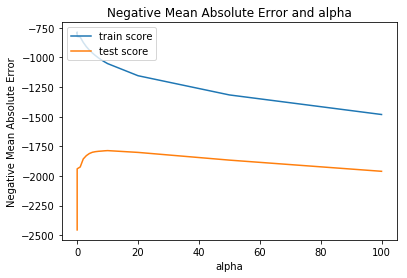

In [54]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [55]:
alpha = 15
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 3.52557941e+02,  9.46530017e+01,  1.34511343e+03, -3.35849314e+02,
        1.16515775e+03,  1.33122540e+03, -1.18579444e+01, -2.84669666e+02,
        1.23313363e+01,  9.29481098e+02,  3.23313329e+02, -2.04711197e+01,
       -8.41293665e+01,  2.21783691e+02,  1.66376475e+02,  6.11555386e+01,
       -1.75468993e+01,  2.28698304e+02, -2.11820147e+02,  4.11053298e+02,
        1.01320701e+02,  2.63588369e+01, -5.29501748e+02, -2.71545584e+02,
       -2.23762142e+02, -2.44396310e+02,  2.61656901e+02,  9.20191503e+02,
       -1.93176012e+01, -2.18315631e+02,  3.13602886e+02,  2.38744211e+01,
        3.92105941e+00,  9.46640067e+01, -4.24237855e+02, -5.81409615e+02,
       -1.05817250e+02,  2.93070489e+02, -2.36048487e+02,  9.46640067e+01,
        5.15255069e+01, -1.79077288e+02,  2.11820147e+02, -1.44440927e-28,
       -3.95308641e+00, -1.36403005e+02, -1.44440927e-28,  3.35662090e+02,
        1.46679730e+03,  1.05750051e+03, -1.30931401e+02, -3.49739603e+02,
       -2.82007527e+02, -

## Lasso

In [56]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [57]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.020253,0.000703,-2200.571734,-792.317797,0.0001,{'alpha': 0.0001},15,-2324.752863,-707.533143,-1442.052401,...,-1582.911324,-825.366072,-3365.795489,-900.619438,-2332.060832,-714.974164,0.003051,5.114743e-04,682.944225,72.696148
1,0.015039,0.000402,-2200.636114,-792.315096,0.001,{'alpha': 0.001},16,-2325.597811,-707.541145,-1441.914232,...,-1582.918610,-825.357146,-3365.543227,-900.608340,-2331.902321,-714.974339,0.001144,2.010351e-04,682.915034,72.690031
2,0.017645,0.000603,-2201.283963,-792.291655,0.01,{'alpha': 0.01},17,-2334.050379,-707.632117,-1440.536627,...,-1582.991423,-825.273418,-3363.022314,-900.497476,-2330.328840,-714.975747,0.002753,2.004154e-04,682.636312,72.627018
3,0.014738,0.000502,-2204.263131,-792.251073,0.05,{'alpha': 0.05},18,-2371.746047,-708.062390,-1434.479193,...,-1583.311429,-825.058880,-3351.844342,-900.011123,-2323.622243,-715.024017,0.001212,5.223489e-07,681.694030,72.353255
4,0.016644,0.000502,-2208.163365,-792.236231,0.1,{'alpha': 0.1},20,-2419.028230,-708.611287,-1426.999122,...,-1583.704217,-824.854499,-3337.915603,-899.429607,-2315.839602,-715.099045,0.001397,7.776979e-07,681.198312,72.023011


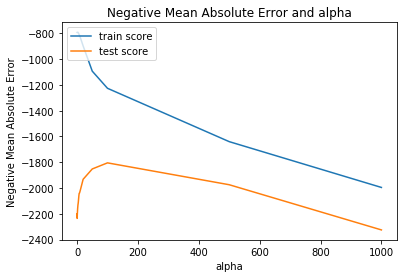

In [58]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [59]:
alpha =100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
lasso.coef_

array([   0.        ,   -0.        , 1747.1052243 ,  -82.23183774,
       1780.64173078,  788.28807799,   -0.        ,   -0.        ,
          0.        , 1017.48820119,   84.89633333,    0.        ,
         -0.        ,    0.        ,   -0.        ,   -0.        ,
          0.        ,  246.519852  ,  -73.38572878,  120.56790634,
          0.        ,    0.        , -187.60748943,    0.        ,
        -96.25412649, -134.39227325,  294.27227486, 1218.02281069,
          0.        ,   -0.        ,    0.        ,   -0.        ,
         -0.        ,    0.        ,   -0.        , -202.47407284,
         -0.        ,  197.70712322,   -0.        ,    0.        ,
         -0.        ,   -0.        ,   58.81424436,   -0.        ,
          0.        ,   -0.        ,   -0.        ,  186.35685239,
       1805.30123983, 1210.72936345,    0.        ,   -0.        ,
         -0.        ,   78.54297249,  796.29612837,    0.        ,
         -0.        , -397.80411254,  -58.198149  , -377.78256